# model interpretation using SHAP (shapley values) for both global model interpretation and local instance interpretation

## load model to be explained
This approach does not work out of the box, because although the autoML model is a random forest model, it is of a different python object nature, which is not recognized by the SHAP package.

In [1]:
import pickle
filehandler = open(b"../automl_tutorials/diabetes_hyperopt_automl.model","rb")
hs_model = pickle.load(filehandler) #hyperopt-sklearn model

## Load train and test data

In [31]:
import pandas as pd
df_train = pd.read_csv("../automl_tutorials/diabetes_train.csv")
df_test = pd.read_csv("../automl_tutorials/diabetes_test.csv")

## Let's build a randomforest model using the training data using the hyperopt-sklearn autoML recommended parameters

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_sk_model = RandomForestRegressor(criterion='absolute_error', max_depth=4,
                      max_features='sqrt', max_leaf_nodes=15,
                      min_impurity_decrease=0.02, min_samples_split=3,
                      n_estimators=2669, n_jobs=1, random_state=0,
                      verbose=False)
rf_sk_model.fit(df_train.iloc[:,0:10], df_train['target'])

RandomForestRegressor(criterion='absolute_error', max_depth=4,
                      max_features='sqrt', max_leaf_nodes=15,
                      min_impurity_decrease=0.02, min_samples_split=3,
                      n_estimators=2669, n_jobs=1, random_state=0,
                      verbose=False)

## Let's save this model

In [4]:
import pickle
filehandler_rf = open(b"diabetes_rf_sk.model","wb")
pickle.dump(rf_sk_model,filehandler_rf)
filehandler_rf.close()

In [20]:
rf_sk_model

RandomForestRegressor(criterion='absolute_error', max_depth=4,
                      max_features='sqrt', max_leaf_nodes=15,
                      min_impurity_decrease=0.02, min_samples_split=3,
                      n_estimators=2669, n_jobs=1, random_state=0,
                      verbose=False)

In [36]:
#from joblib import dump
#dump(rf_sk_model, "diabetes_rf_sk_model.joblib")

import joblib
from platform import python_version
import numpy as np
import sklearn

meta = {
    'python': python_version(),
    'numpy': np.__version__,
    'sklearn': sklearn.__version__
}

joblib.dump({'model': rf_sk_model, 'metadata': meta}, 'diabetes_rf_sk_model.joblib')

['diabetes_rf_sk_model.joblib']

In [37]:
np.__version__

'2.1.3'

In [26]:
meta

{'python': '3.12.9', 'numpy': '2.1.3', 'sklearn': '1.6.1'}

In [28]:
new_model = joblib.load('diabetes_rf_sk_model.joblib')

In [29]:
new_model

{'model': RandomForestRegressor(criterion='absolute_error', max_depth=4,
                       max_features='sqrt', max_leaf_nodes=15,
                       min_impurity_decrease=0.02, min_samples_split=3,
                       n_estimators=2669, n_jobs=1, random_state=0,
                       verbose=False),
 'metadata': {'python': '3.12.9', 'numpy': '2.1.3', 'sklearn': '1.6.1'}}

## Local interpreation (of an instance, in this case a patient)

In [5]:
import shap
#explainer_shap = shap.TreeExplainer(rf_sk_model)

example_data = shap.utils.sample(df_train.iloc[:,0:10], 100)
shap_explainer =  shap.Explainer(rf_sk_model, example_data) #KernelExplainer

/opt/anaconda3/envs/dltutorials/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
shap_values = shap_explainer(df_train.iloc[:,0:10] ) # it may appear it stopped at 95%, 
                                                     # but it actually finished

 94%|=================== | 331/353 [00:13<00:00]       

In [8]:
shap_explainer.expected_value

np.float64(152.4857324840765)

In [9]:
shap_values.shape

(353, 10)

## Global interpretation
Compared with the permutation importance method, we can see that there are a few advantges of using shap:
- have the importance of the variables ranked from top to bottom
- direction of the impact by color (e.g, ltg, bmi and bp all have positive impact on the outcome, while hdl has negative impact on the outcome with bigger values)
- The distribution of the impact

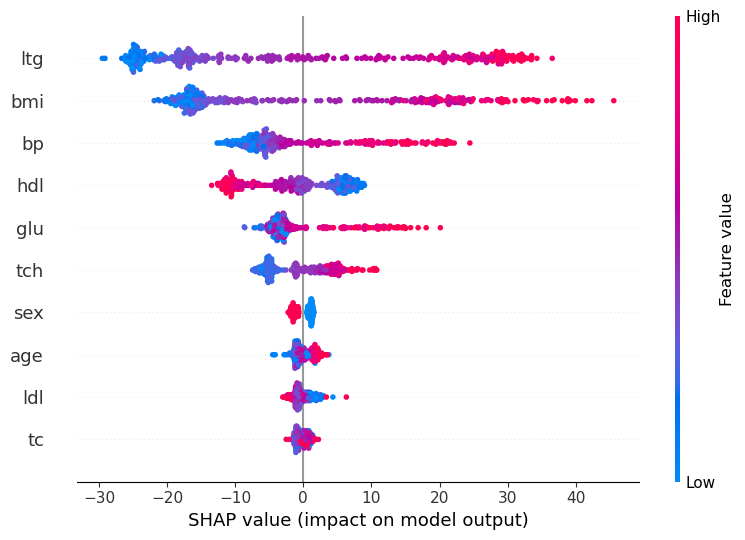

In [10]:
shap.summary_plot(shap_values, df_train.iloc[:,0:10])

### Further examine the global model using heatmap

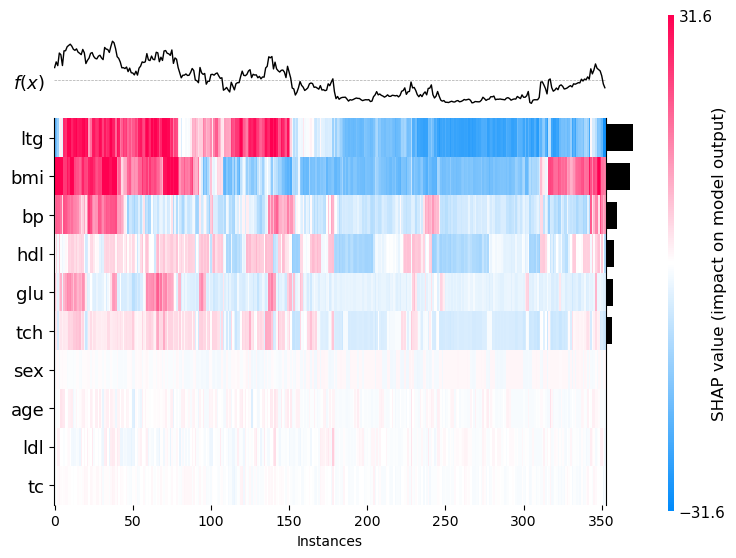

<Axes: xlabel='Instances'>

In [11]:
shap.plots.heatmap(shap_values)

### Further examine the global model using heatmap with ordering

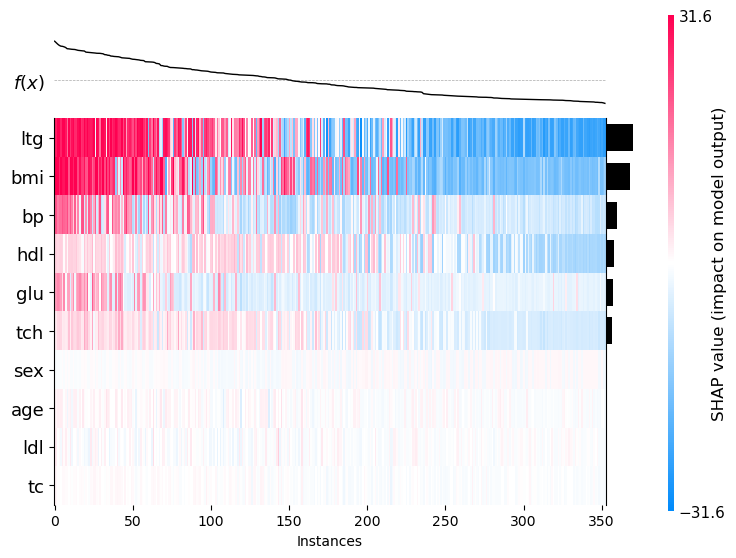

<Axes: xlabel='Instances'>

In [12]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

### let's examine the impact of each variable on the outcome individually

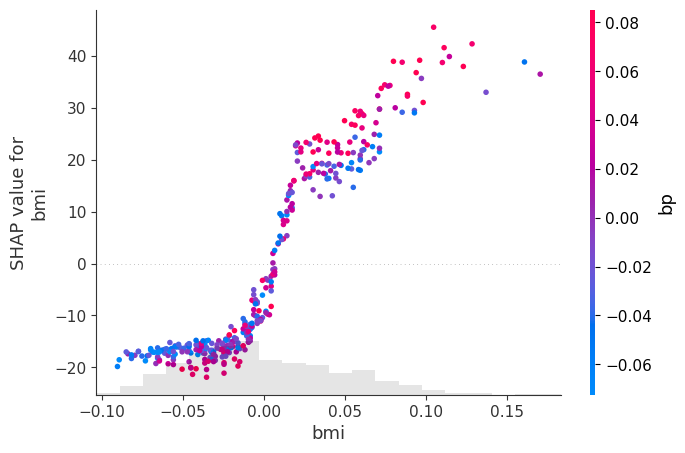

In [13]:
shap.plots.scatter(shap_values[:,"bmi"],color=shap_values)

### the opposite pattern of bmi and hdl is evident here

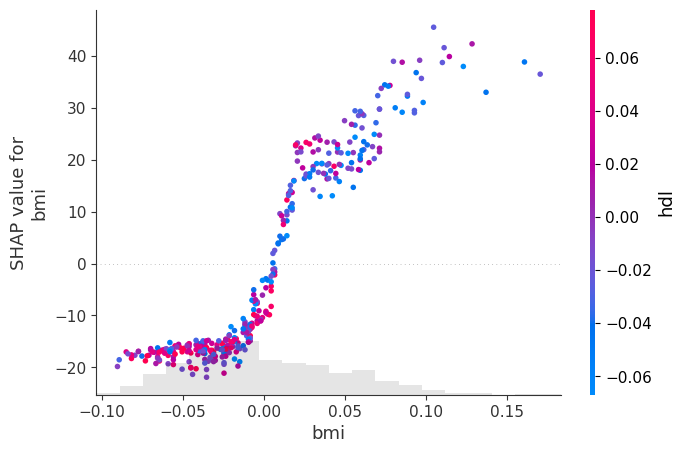

In [14]:
shap.plots.scatter(shap_values[:,"bmi"],color=shap_values[:,"hdl"])

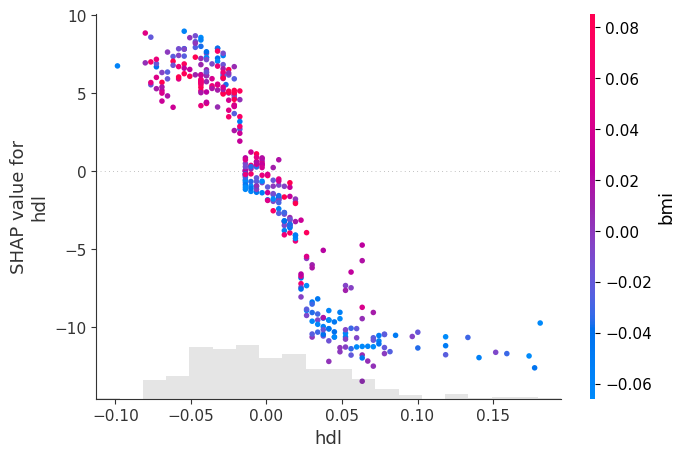

In [15]:
shap.plots.scatter(shap_values[:,"hdl"], color=shap_values) #negative correlation

### the clustering results are not surprising!
- tc, total serum cholesterol
- ldl, low-density lipoproteins
- hdl, high-density lipoproteins
- tch, total cholesterol / HDL
- ltg, possibly log of serum triglycerides level

They are correlated, followed by bmi, the body mass index.

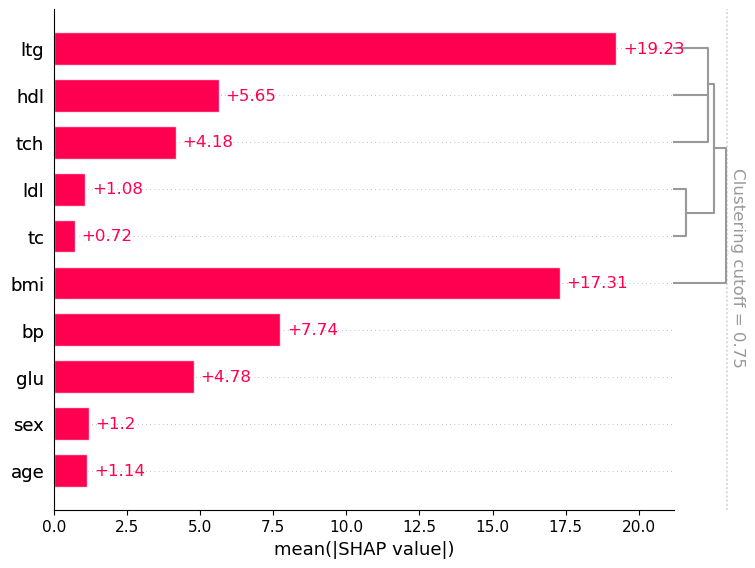

In [16]:
clustering = shap.utils.hclust(df_train.iloc[:,0:10], df_train['target'])
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.75)

## Local interpretation 
- take a patient, the 101th patient as an example
#patient_for_explain = df_train.iloc[100,0:10].

- Below shows the shapley values for each variable for this particular patient 

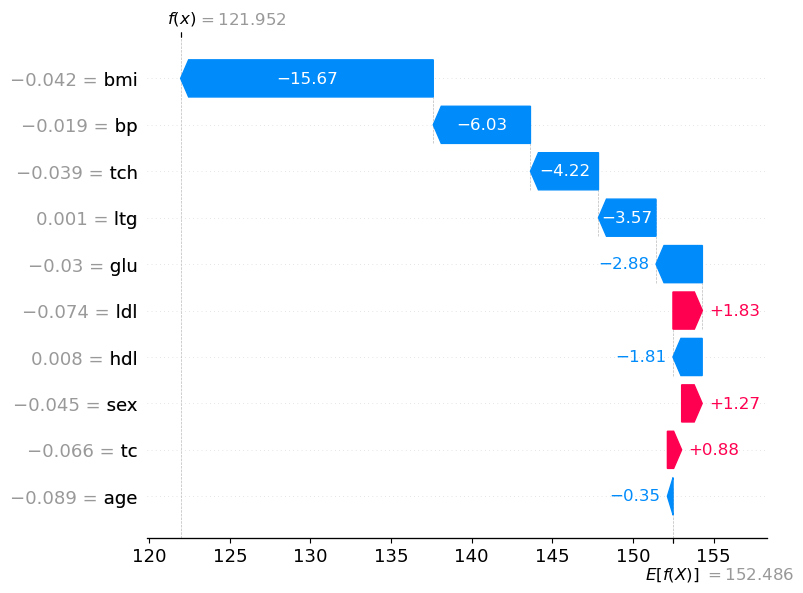

In [17]:
shap.plots.waterfall(shap_values[100])

## We can use interpretation on new data as well (using 50 patients of test data here)

In [18]:
shap_values_new_data = shap_explainer(df_test.iloc[0:50,0:10] )

### plot the shapley values interpretation for the new data
Similar conclusions based on the sample test data, compared to training data

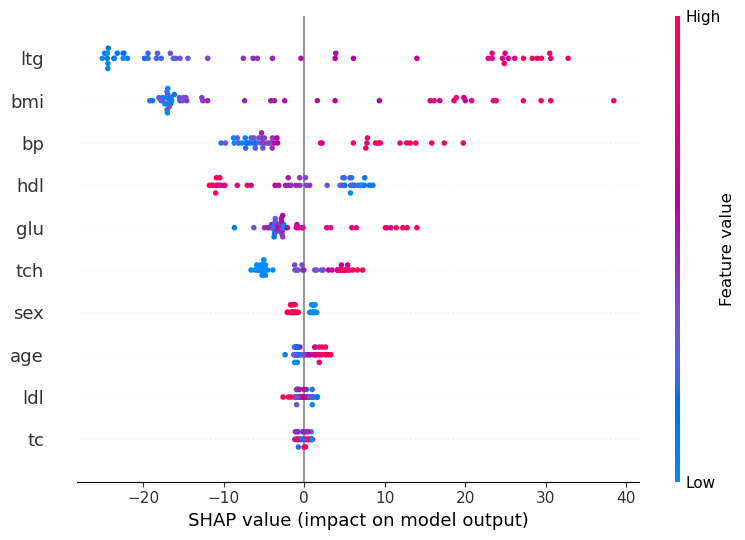

In [19]:
shap.summary_plot(shap_values_new_data, df_test.iloc[0:50,0:10])